In [1]:
import numpy as np
import os
from skimage.measure import block_reduce
from scipy.misc import imread
import cPickle as pkl
import scipy.signal
import numpy.fft as fft
import sys
import optparse
from libtiff import TIFF
from PIL import Image
import re
import itertools
from scipy import ndimage
import pandas as pd
import matplotlib.pyplot as plt

import math
%matplotlib inline

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [2]:
# outdir = '/media/juliana/MAC/data/JR009/20150625b/20150625_JR009_500um_0080Hz/structs'
# outdir = '/media/juliana/MAC/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_blueLED/structs'

# outdir = '/media/juliana/MAC/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_red2/structs'
# outdir = '/media/nas/volume1/widefield/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_red2/structs'


# outdir = '/media/nas/volume1/widefield/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_blueLED/structs'
# H-Up_0_reduce2_avgcycle looks the best (video)
# 

outdir = '/media/nas/volume1/widefield/data/CE004/20160203/anesthetized_bar_0008/structs'
# V-Left_3 or V-Left_1 (both seem ok) -- V-Left_1 slightly better, use this.
# V-Right_3 for sure
# --- looks good
# H-Down_3 looks great on lateral half, H-Down_1 MAY look okay?  check vids...
# --- H-Down_1 video (avg), looks decent!
# --- H-Down_3 vid -- looks very good! -- use H-Down_3

# H-Up_3 looks good on lateral half -- don' have H-Up_1 yet...
# --based on NAS only struct, H-Up_1 looks better, using this one.

os.listdir(outdir)

['D_fft_H-Down_1_(2, 2).hkl',
 'D_fft_H-Down_3_(2, 2).hkl',
 'D_fft_H-Up_0_(2, 2).hkl',
 'D_fft_H-Up_1_(2, 2).hkl',
 'D_fft_H-Up_3_(2, 2).hkl',
 'D_fft_V-Left_1_(2, 2).hkl',
 'D_fft_V-Left_2_(2, 2).hkl',
 'D_fft_V-Left_3_(2, 2).hkl',
 'D_fft_V-Right_1_(2, 2).hkl',
 'D_fft_V-Right_3_(2, 2).hkl',
 'D_target_H-Down_1_(2, 2)_.pkl',
 'D_target_H-Down_3_(2, 2)_.pkl',
 'D_target_H-Up_0_(2, 2)_.pkl',
 'D_target_H-Up_1_(2, 2)_.pkl',
 'D_target_H-Up_3_(2, 2)_.pkl',
 'D_target_V-Left_1_(2, 2)_.pkl',
 'D_target_V-Left_2_(2, 2)_.pkl',
 'D_target_V-Left_3_(2, 2)_.pkl',
 'D_target_V-Right_1_(2, 2)_.pkl',
 'D_target_V-Right_3_(2, 2)_.pkl',
 'Target_fft_V-Left_1_(1, 1)_nas.pkl',
 'Target_fft_V-Right_1_(1, 1)_nas.pkl',
 'Target_fft_H-Up_1_(1, 1)_nas.pkl',
 'Target_fft_V-Left_2_(1, 1)_nas.pkl',
 'Target_fft_H-Up_3_(1, 1)_nas.pkl',
 'Target_fft_V-Right_3_(1, 1)_nas.pkl',
 'Target_fft_V-Left_3_(1, 1)_nas.pkl',
 'Target_fft_H-Up_0_(1, 1)_nas.pkl',
 'Target_fft_H-Down_1_(1, 1)_nas.pkl',
 'Target_fft_H-Down_3

In [3]:
rundir = os.path.split(outdir)[0]
sessiondir = os.path.split(rundir)[0]
reduceit=0

/media/nas/volume1/widefield/data/CE004/20160203/anesthetized_bar_0008
['surface_20160203.tif']
['surface_20160203.tif']
.tif


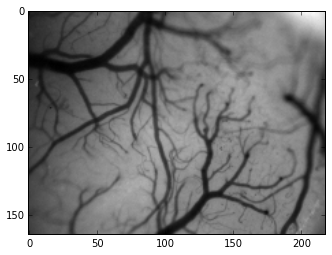

In [4]:
#################################################################################
# GET BLOOD VESSEL IMAGE:
#################################################################################

rundir = os.path.split(outdir)[0]
sessiondir = os.path.split(rundir)[0]
reduceit=0

folders = os.listdir(rundir)
figpath = [f for f in folders if f == 'figures']
print rundir

if figpath:
    figdir = figpath[0]
    tmp_ims = os.listdir(os.path.join(sessiondir, figdir))
    print tmp_ims
    surface_words = ['surface', 'GREEN', 'green', 'Surface']
    ims = [i for i in tmp_ims if any([word in i for word in surface_words])]
    print ims
    impath = os.path.join(sessiondir, figdir, ims[0])
    # image = Image.open(impath) #.convert('L')
    # imarray = np.asarray(image)
    print os.path.splitext(impath)[1]
    if os.path.splitext(impath)[1] == '.tif':
        tiff = TIFF.open(impath, mode='r')
        surface = tiff.read_image().astype('float')
        tiff.close()
        plt.imshow(surface)
    else:
        image = Image.open(impath) #.convert('L')
        surface = np.asarray(image)


else: # NO BLOOD VESSEL IMAGE...
    surface = np.zeros([200,300])

if reduceit:
    surface = block_reduce(surface, reduce_factor, func=np.mean)

plt.imshow(surface, cmap='gray')

In [5]:

files = os.listdir(outdir)
files = [f for f in files if os.path.splitext(f)[1] == '.pkl']
print files
# dstructs = [f for f in files if 'D_target_FFT' in f and str(reduce_factor) in f]
# if not dstructs:
#     dstructs = [f for f in files if 'D_' in f and str(reduce_factor) in f] # address older analysis formats

# MEAN-SUBTRACTED ANALYSIS:
# append = 'nas'
dstructs = [f for f in files if 'Target_fft_' in f]
# dstructs = [d for d in dstructs if append in d]
print dstructs
D = dict()
for f in dstructs:
    outfile = os.path.join(outdir, f)
    with open(outfile,'rb') as fp:
        D[f] = pkl.load(fp)

astructs = [f for f in files if 'Amplitudes' in f]
A = dict()
for f in astructs:
	outfile = os.path.join(outdir, f)
	with open(outfile,'rb') as fp:
		A[f] = pkl.load(fp)
print A.keys()

a_keys = A.keys() #[0]
print a_keys

['D_target_H-Down_1_(2, 2)_.pkl', 'D_target_H-Down_3_(2, 2)_.pkl', 'D_target_H-Up_0_(2, 2)_.pkl', 'D_target_H-Up_1_(2, 2)_.pkl', 'D_target_H-Up_3_(2, 2)_.pkl', 'D_target_V-Left_1_(2, 2)_.pkl', 'D_target_V-Left_2_(2, 2)_.pkl', 'D_target_V-Left_3_(2, 2)_.pkl', 'D_target_V-Right_1_(2, 2)_.pkl', 'D_target_V-Right_3_(2, 2)_.pkl', 'Target_fft_V-Left_1_(1, 1)_nas.pkl', 'Target_fft_V-Right_1_(1, 1)_nas.pkl', 'Target_fft_H-Up_1_(1, 1)_nas.pkl', 'Target_fft_V-Left_2_(1, 1)_nas.pkl', 'Target_fft_H-Up_3_(1, 1)_nas.pkl', 'Target_fft_V-Right_3_(1, 1)_nas.pkl', 'Target_fft_V-Left_3_(1, 1)_nas.pkl', 'Target_fft_H-Up_0_(1, 1)_nas.pkl', 'Target_fft_H-Down_1_(1, 1)_nas.pkl', 'Target_fft_H-Down_3_(1, 1)_nas.pkl', 'Target_fft_V-Right_3_(1, 1)_nas_DC.pkl', 'Target_fft_V-Left_3_(1, 1)_nas_DC.pkl', 'Target_fft_H-Up_3_(1, 1)_nas_DC.pkl', 'Target_fft_H-Down_3_(1, 1)_nas_DC.pkl', 'Target_fft_V-Left_1_(1, 1)_nas_DC.pkl', 'Target_fft_V-Right_1_(1, 1)_nas_DC.pkl', 'Target_fft_H-Down_1_(1, 1)_nas_DC.pkl', 'Target_ff

In [38]:
curr_key = ''
a_key = ''

cond = 'Up'
append='fft'
a_key = [a for a in a_keys if cond in a and append in a][0]
print a_key


run_num = 3 #3 #3
reduce_factor = (1, 1) #(1, 1) #(2, 2)
append = 'nas_DC'  #'nas_DC' #detrendfirst' #filter' #'nas'
cond_type = cond

run_conds = [cond_type, str(run_num)+'_', str(reduce_factor), append]

tmp_keys = [k for k in dstructs if all([c in k for c in run_conds])] #[0]
if len(tmp_keys) > 1:
    print "More than 1 match found: "
    print tmp_keys
elif tmp_keys == []:
    print "No matches found from list: "
    print dstructs
else:
    curr_key = tmp_keys[0]
#     print "Curr key is: ", leftkey

# curr_key = [d for d in D.keys() if cond in d][0]
print "a_key: ", a_key
print "curr_key: ", curr_key

IndexError: list index out of range

Amplitudes_H-Down_3_(1, 1)_fft.pkl
(164, 218)


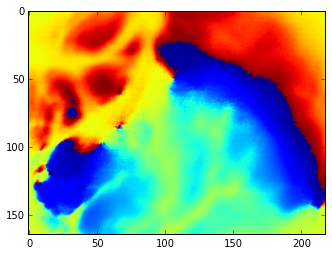

In [34]:
# Get the stuffs.

ratio_map = A[a_key]['ratio_map']
phase_map = np.angle(D[curr_key]['ft'])
print a_key

plt.imshow(phase_map)
print phase_map.shape

# print ratio_map[120, 200]

Hue range:  1.54612632037e-07 0.999973696553
Val range:  3.18512498465e-05 0.00989814464118


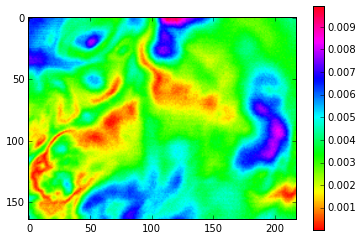

In [35]:
# NORMALIZE to HSV:

Ny = len(D[curr_key]['freqs'])/2.

old_min = -math.pi #phase_map.min()
old_max = math.pi #phase_map.max()
new_min = 0
new_max = 1
normed_phase_map = np.zeros(phase_map.shape)
for x in range(phase_map.shape[0]):
    for y in range(phase_map.shape[1]):
        old_val = phase_map[x, y]
        normed_phase_map[x, y] = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min

# old_min = mag_map.min()
# old_max = mag_map.max()
# new_min = 0
# new_max = 1
# normed_mag_map = np.zeros(mag_map.shape)
# for x in range(mag_map.shape[0]):
#     for y in range(mag_map.shape[1]):
#         old_val = mag_map[x, y]
#         normed_mag_map[x, y] = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min

hue = normed_phase_map
sat = np.ones(hue.shape)
val = ratio_map #/Ny #normed_mag_map

HSV = np.ones(val.shape + (3,))
HSV[...,0] = hue
HSV[...,2] = sat * 1
HSV[...,1] = val * 10

plt.imshow(val, cmap='hsv')
plt.colorbar()

print "Hue range: ", hue.min(), hue.max()
print "Val range: ", val.min(), val.max()

In [36]:
import colorsys
hsv_to_rgb = np.empty(HSV.shape)

for i in range(HSV.shape[0]):
    for j in range(HSV.shape[1]):

            hsv_to_rgb[i, j, :] = colorsys.hsv_to_rgb(HSV[i,j,:][0],HSV[i,j,:][1],HSV[i,j,:][2])


0.901018553588 1.0
/media/nas/volume1/widefield/data/CE004/20160203/anesthetized_bar_0008/PHASE_map_HSV_Amplitudes_H-Down_3_(1, 1)_fft.pkl_Target_fft_H-Down_3_(1, 1)_nas_DC.pkl.jpg


<matplotlib.colorbar.Colorbar instance at 0x7f14f568f1b8>

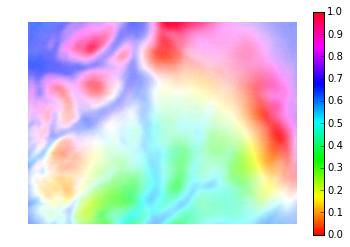

In [37]:
# MASK:
print hsv_to_rgb.min(), hsv_to_rgb.max()

old_min = hsv_to_rgb.min()
old_max = hsv_to_rgb.max()
new_min = 0
new_max = 1
renorm_rgb = np.zeros(hsv_to_rgb.shape)
for x in range(hsv_to_rgb.shape[0]):
    for y in range(hsv_to_rgb.shape[1]):
        old_val = hsv_to_rgb[x, y]
        renorm_rgb[x, y] = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min



plt.imshow(surface, 'gray')
plt.imshow(renorm_rgb, 'hsv') #, vmin=0, vmax=1)
plt.axis('off')
# plt.colorbar()


imname = "PHASE_map_HSV_%s_%s" % (a_key, curr_key)
savedir = os.path.split(outdir)[0]
# impath = os.path.join(savedir, imname+'.svg')
# plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(savedir, imname+'.jpg')
plt.savefig(impath, format='jpg')

print impath

plt.colorbar()

/media/nas/volume1/widefield/data/JR009/20150625_block2/20150625_JR009_500um_0080Hz_blueLED/H_up_normalized_legend.jpg


<matplotlib.colorbar.Colorbar instance at 0x7f514b17f050>

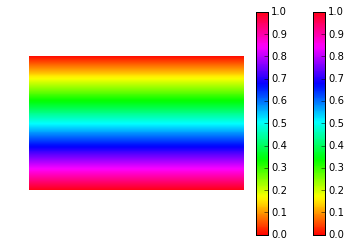

In [381]:
# if create_legend:

screen_size = [400,250]
H_up_legend = np.zeros((screen_size[1], screen_size[0]))
# with shift, 0 to -pi is equiv to 1-->0

nspaces_start = np.linspace(0, 1, screen_size[1])
for i in range(screen_size[0]):
    H_up_legend[0:screen_size[1], i] = nspaces_start

plt.imshow(H_up_legend, cmap='hsv')
plt.axis('off')
plt.colorbar()

impath = os.path.join(savedir, 'H_up_normalized_legend'+'.jpg')
plt.savefig(impath, format='jpg')

print impath
plt.colorbar()


<matplotlib.colorbar.Colorbar instance at 0x7f5150d09830>

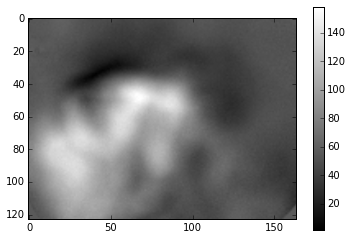

In [331]:
plt.imshow(A[a_key]['dB_map'], cmap='gray')
plt.colorbar()

In [382]:
# upkey = [k for k in D.keys() if 'H' in k and '_'+'00' in k and 'Up' in k and '00' in k][0]
# upkey = [k for k in D.keys() if 'H' in k and '_'+run_num+'_' in k and 'Up' in k][0]

# downkey = [k for k in D.keys() if 'H' in k and '_'+run_num in k and 'Down' in k][0]

# leftkey = [k for k in D.keys() if 'V' in k and '_'+run_num in k and 'Left' in k][0]
# rightkey = [k for k in D.keys() if 'V' in k and '_'+run_num in k and 'Right' in k][0]


# upkey = [k for k in D.keys() if 'Up' in k and '_'+run_num in k][0]
# downkey = [k for k in D.keys() if 'Down' in k and '_'+run_num in k][0]

bottomkeys = [k for k in D.keys() if 'Bottom' in k or 'Up' in k] #[0]
topkeys= [k for k in D.keys() if 'Top' in k or 'Down' in k] #[0]

leftkeys = [k for k in D.keys() if 'Left' in k] #[0]
rightkeys = [k for k in D.keys() if 'Right' in k] #[0]

el_keys = [topkeys, bottomkeys]

az_keys = [leftkeys, rightkeys]

print "AZ keys: ", az_keys
print "EL keys: ", el_keys

# curr_keys = [leftkey, rightkey, topkey, bottomkey]


AZ keys:  [['Target_fft_V-Left_0_(2, 2)_nomean.pkl', 'Target_fft_V-Left_0_(2, 2)_ratio.pkl', 'Target_fft_V-Left_0_(2, 2)_filter.pkl', 'Target_fft_V-Left_0_(2, 2)_subtractmean.pkl', 'Target_fft_V-Left_0_(2, 2)_detrendfirst.pkl', 'Target_fft_V-Left_0_(2, 2)_detrendlast.pkl', 'Target_fft_V-Left_0_(2, 2)_.pkl'], ['Target_fft_V-Right_0_(2, 2)_.pkl', 'Target_fft_V-Right_0_(2, 2)_detrendfirst.pkl', 'Target_fft_V-Right_0_(2, 2)_filter.pkl', 'Target_fft_V-Right_0_(2, 2)_detrendlast.pkl']]
EL keys:  [['Target_fft_H-Down_0_(2, 2)_.pkl', 'Target_fft_H-Down_0_(2, 2)_detrendfirst.pkl', 'Target_fft_H-Down_0_(2, 2)_filter.pkl'], ['Target_fft_H-Up_0_(2, 2)_.pkl', 'Target_fft_H-Up_0_(2, 2)_detrendfirst.pkl', 'Target_fft_H-Up_0_(2, 2)_filter.pkl']]


Curr key is:  Target_fft_V-Left_0_(2, 2)_detrendfirst.pkl
Showing:  Target_fft_V-Left_0_(2, 2)_detrendfirst.pkl


(-0.5, 399.5, 249.5, -0.5)

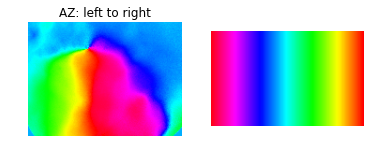

In [385]:
######################################################################
# V-LEFT:
######################################################################

run_num = 0
reduce_factor = (2, 2) #(1, 1) #(2, 2)
append = 'detrendfirst'  #'nas_DC' #detrendfirst' #filter' #'nas'
cond_type = 'Left'

run_conds = [cond_type, str(run_num)+'_', str(reduce_factor), append]

tmp_keys = [k for k in leftkeys if all([c in k for c in run_conds])] #[0]
if len(tmp_keys) > 1:
    print "More than 1 match found: "
    print tmp_keys
elif tmp_keys == []:
    print "No matches found from list: "
    print leftkeys
else:
    leftkey = tmp_keys[0]
    print "Curr key is: ", leftkey

leftmap = D[leftkey]['ft']

currkey = leftkey
currmap = leftmap

print "Showing: ", currkey
fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(np.angle(currmap), cmap='hsv', vmin=-1*math.pi, vmax=1*math.pi)
plt.title('AZ: left to right')
plt.axis('off')

ax = fig.add_subplot(1,2,2)
plt.imshow(V_left_legend, cmap='hsv')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.axis('off')

In [386]:
######################################################################
# FIGURES: PHASSSSS
######################################################################

currkey = topkey
currmap = D[currkey]['ft']

print "Showing: ", currkey
fig = plt.figure(figsize=(10,5))

plt.imshow(np.angle(currmap), cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
# plt.title('AZ: left to right')
plt.axis('off')

imname = 'PHASE_map_'+currkey
structdir = os.path.split(outdir)[0]
impath = os.path.join(os.path.split(structdir)[0], imname+'.svg')
plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(outdir, imname+'.jpg')
plt.savefig(impath, format='jpg')


print impath

KeyError: 'Target_fft_H-Down_3_(1, 1)_nas.pkl'

Showing:  Target_fft_H-Down_3_(1, 1)_nas.pkl
7500.5
/media/nas/volume1/widefield/data/CE004/20160203/anesthetized_bar_0008/structs/MAG_map_Target_fft_H-Down_3_(1, 1)_nas.pkl.jpg


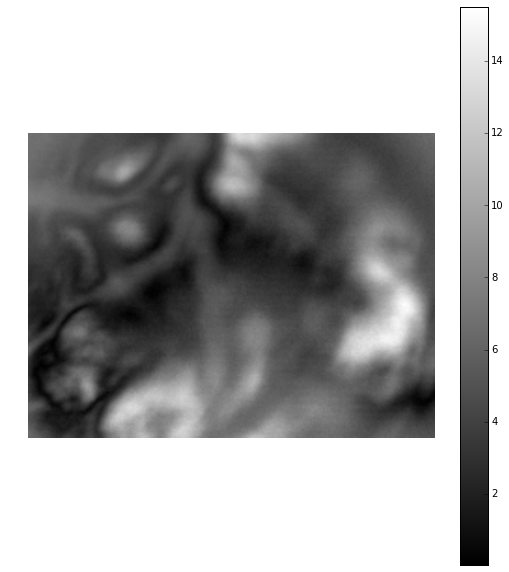

In [119]:
######################################################################
# FIGURES: MAG MAG MAG
######################################################################

print "Showing: ", currkey
fig = plt.figure(figsize=(20,10))

Ny = len(D[currkey]['freqs'])/2.
print Ny
fig.add_subplot(1,2,1)
plt.imshow(np.abs(currmap)/Ny, cmap='gray') #, vmin=-1*math.pi, vmax=1*math.pi)
# plt.title('AZ: left to right')
plt.axis('off')
plt.colorbar()

imname = 'MAG_map_'+currkey
structdir = os.path.split(outdir)[0]
impath = os.path.join(os.path.split(structdir)[0], imname+'.svg')
plt.savefig(impath, format='svg', dpi=1200)

impath = os.path.join(outdir, imname+'.jpg')
plt.savefig(impath, format='jpg')


print impath

(164, 218)


(-0.5, 217.5, 163.5, -0.5)

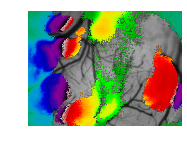

In [72]:
# import matplotlib.cm as cm

use_mean_intensity = 0 # set to 1 if want to threshold with mean intensity values instead of magnitude
use_log = 1
threshold = 0.2

curr_key=leftkey

Ny = len(D[curr_key]['freqs'])/2.
mag_map = D[curr_key]['mag_map']/Ny
phase_map = D[curr_key]['phase_map']

#-----------------------------------------------------------------
# Overlaid Phase-map, thresholded
#-----------------------------------------------------------------

fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(surface,cmap='gray')
print surface.shape

if use_mean_intensity:
    mean_intensity = D[curr_key]['mean_intensity']
    [x, y] = np.where(mean_intensity >= threshold*mean_intensity.max())
    phase_mask = np.ones(mean_intensity.shape) * 100
    # phase_mask[x, y] = phase_map[x, y]
    phase_mask[x, y] = D[curr_key]['phase_map'][x, y]
    tit = 'Threshold, %.2f of mean intensity max' % (threshold)

else:
    if use_log:
        [x, y] = np.where(np.log(mag_map) >= threshold * np.log(mag_map.max()))
    else:
        [x, y] = np.where(mag_map >= threshold * mag_map.max())
    phase_mask = np.ones(mag_map.shape) * 100
    phase_mask[x, y] = phase_map[x, y]
    tit = 'Threshold, %.2f of log max magnitude' % (threshold)

[nullx, nully] = np.where(phase_mask == 100)
phase_mask[nullx, nully] = np.nan
phase_mask = np.ma.array(phase_mask)
plt.imshow(phase_mask, cmap='spectral', vmin=-1*math.pi, vmax=math.pi)
plt.axis('off')


# #-----------------------------------------------------------------
# # LEGEND
# #-----------------------------------------------------------------

# ax = fig.add_subplot(1,2,2, projection='polar')
# ax.set_theta_zero_location('W') # W puts 0 on RIGHT side...

# if CW:
#     ax._direction = 2*np.pi # object moves toward bottom first (CW)
# else:
#     ax._direction = -2*np.pi # objecct moves toward top first (CCW)

# norm = mpl.colors.Normalize(vmax=1*np.pi, vmin=-1*np.pi)
# #norm = mpl.colors.Normalize(vmax=2*np.pi, vmin=0)
# cb = mpl.colorbar.ColorbarBase(ax, cmap=cm.get_cmap('spectral'),
#                                 norm=norm, orientation='horizontal')
# # cb.ax.invert_xaxis()
# # cb.outline.set_visible(False)
# # ax.set_axis_off()
# ax.set_rlim([-1, 1])
# ax.axis('off')

# if CW:
#     imname = 'CW_phase_overlay_withkey_threshold%.2f' % threshold
# else:
#     imname = 'CCW_phase_overlay_withkey_threshold%.2f' % threshold
# impath = os.path.join(outdir, imname+'.eps')
# plt.savefig(impath, format='svg', dpi=1200)

# impath = os.path.join(outdir, imname+'.jpg')
# plt.savefig(impath, format='jpg')


# print impath

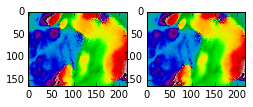

In [38]:
phasemap = np.angle(leftmap)
plt.imshow(phasemap, cmap='spectral')

old_min = phasemap.min()
old_max = phasemap.max()
new_min = 0
new_max = 1

normed_phasemap = np.zeros(phasemap.shape)
for x in range(phasemap.shape[0]):
    for y in range(phasemap.shape[1]):
        old_val = phasemap[x, y]
        normed_phasemap[x, y] = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min

# normed_phasemap = 

im = Image.fromarray(np.uint8(plt.cm.spectral(normed_phasemap)*255))

plt.subplot(1,3,1)
plt.imshow(phasemap, cmap='spectral')
plt.colorbar

plt.subplot(1,3,2)
plt.imshow(normed_phasemap, cmap='spectral')
imname = os.path.join(os.path.split(outdir)[0], 'V-Left_0_im.jpg')
im.save(imname)
# plt.subplot(1,3,3)
# plt.colorbar()


<matplotlib.colorbar.Colorbar instance at 0x7f5159c398c0>

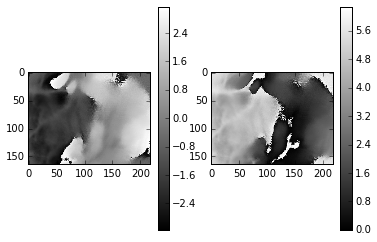

In [39]:
import math
phase_left = np.angle(leftmap)
# phase_right = np.angle(rightmap)

for x in range(phase_left.shape[0]):
    for y in range(phase_left.shape[1]):
        if phase_left[x,y] < 0:
            phase_left[x,y] += 2*math.pi

# for x in range(phase_right.shape[0]):
#     for y in range(phase_right.shape[1]):
#         if phase_right[x,y] < 0:
#             phase_right[x,y] += 2*math.pi

plt.subplot(1,2,1)
plt.imshow(np.angle(leftmap), cmap='gray')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(phase_left, cmap='gray')
plt.colorbar()

In [397]:
# compute gradient of image
I = Image.open(imname)

p = phase_left

# plt.imshow(p)
gx, gy = np.gradient(p)
# print "gx =", gx
# print "gy =", gy

# plotting
plt.close("all")
plt.figure()
plt.suptitle("Image, and it gradient along each axis")
ax = plt.subplot("131")
ax.axis("off")
ax.imshow(p, cmap='spectral')
ax.set_title("image")

ax = plt.subplot("132")
ax.axis("off")
ax.imshow(gx)
ax.set_title("gx")

ax = plt.subplot("133")
ax.axis("off")
ax.imshow(gy)
ax.set_title("gy")
plt.show()


IOError: [Errno 2] No such file or directory: 'PHASE_map_HSV_Amplitudes_H-Up_0_(2, 2)_fft.pkl'

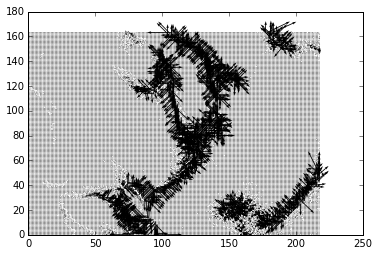

In [271]:
from pylab import *
Q = quiver(gx, gy)

# l,r,b,t = axis()
# dx, dy = r-l, t-b
# axis([l-0.05*dx, r+0.05*dx, b-0.05*dy, t+0.05*dy])

Curr key is:  Target_fft_V-Right_0_(2, 2)_detrendlast.pkl
Showing:  Target_fft_V-Right_0_(2, 2)_detrendlast.pkl


NameError: name 'V_right_legend' is not defined

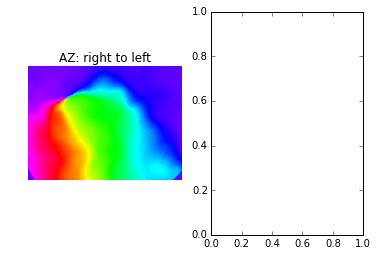

In [395]:
######################################################################
# V-RIGHT:
######################################################################

# run_num = 0 #3
# reduce_factor = (2, 2) #(1, 1)
# append = 'filter' #'nas'
# cond_type = 'Right'

run_num = 0 #0 #3
reduce_factor = (2, 2) #(2, 2) #(1, 1) #(2, 2)
append = 'detrendlast' #nas_DC' #filter' #'nas'
cond_type = 'Right'

run_conds = [cond_type, str(run_num)+'_', str(reduce_factor), append]
tmp_keys = [k for k in rightkeys if all([c in k for c in run_conds])] #[0]
if len(tmp_keys) > 1:
    print "More than 1 match found: "
    print tmp_keys
elif tmp_keys == []:
    print "No matches found from list: "
    print rightkeys
else:
    rightkey = tmp_keys[0]
    print "Curr key is: ", rightkey

rightmap = D[rightkey]['ft']

currkey = rightkey
currmap = rightmap

print "Showing: ", currkey
fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(np.angle(currmap), cmap='hsv', vmin=-1*math.pi, vmax=1*math.pi)
plt.axis('off')
plt.title('AZ: right to left')

ax = fig.add_subplot(1,2,2)
plt.imshow(V_right_legend, cmap='hsv')
plt.axis('off')


Curr key is:  Target_fft_H-Down_0_(2, 2)_detrendfirst.pkl
Showing:  Target_fft_H-Down_0_(2, 2)_detrendfirst.pkl


(-0.5, 399.5, 249.5, -0.5)

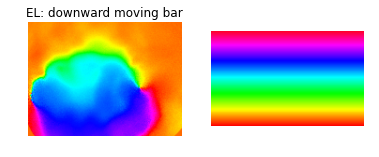

In [396]:
######################################################################
# H-TOP: DOWNward moving bar
######################################################################

run_num = 0 #0 #3
reduce_factor = (2, 2) #(2, 2) #(1, 1)
append = 'detrendfirst' #_nas.pkl' #'detrendfirst' #filter' #'filter' #'nas'
cond_type = 'Down'
# cond_type = 'Top'

run_conds = [cond_type, str(run_num)+'_', str(reduce_factor), append]
tmp_keys = [k for k in topkeys if all([c in k for c in run_conds])] #[0]
if len(tmp_keys) > 1:
    print "More than 1 match found: "
    print tmp_keys
elif tmp_keys == []:
    print "No matches found from list: "
    print topkeys
else:
    topkey = tmp_keys[0]
    print "Curr key is: ", topkey

topmap = D[topkey]['ft']

currkey = topkey
currmap = topmap

print "Showing: ", currkey
fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(np.angle(currmap), cmap='hsv',  vmin=-1*math.pi, vmax=1*math.pi)
plt.axis('off')
plt.title('EL: downward moving bar')

ax = fig.add_subplot(1,2,2)
plt.imshow(H_down_legend, cmap='hsv')
plt.axis('off')


Curr key is:  Target_fft_H-Up_0_(2, 2)_detrendfirst.pkl
Showing:  Target_fft_H-Up_0_(2, 2)_detrendfirst.pkl


(-0.5, 399.5, 249.5, -0.5)

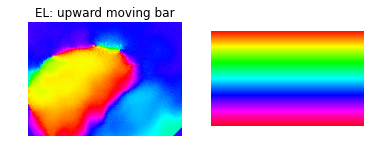

In [399]:
######################################################################
# H-BOTTOM :  UPward moving bar 
######################################################################

run_num = 0 #0 #3
reduce_factor = (2, 2) #(2, 2) #(1, 1)
append = 'detrendfirst'#'nas_DC' #nas_DC' #filter' #'nas'
cond_type = 'Up'
# cond_type = 'Bottom'

run_conds = [cond_type, str(run_num)+'_', str(reduce_factor), append]
tmp_keys = [k for k in bottomkeys if all([c in k for c in run_conds])] #[0]
if len(tmp_keys) > 1:
    print "More than 1 match found: "
    print tmp_keys
elif tmp_keys == []:
    print "No matches found from list: "
    print bottomkeys
else:
    bottomkey = tmp_keys[0]
    print "Curr key is: ", bottomkey

bottommap = D[bottomkey]['ft']

currkey = bottomkey
currmap = bottommap

print "Showing: ", currkey
fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(np.angle(currmap), cmap='hsv',  vmin=-1*math.pi, vmax=1*math.pi)
plt.title('EL: upward moving bar')
plt.axis('off')

ax = fig.add_subplot(1,2,2)
plt.imshow(H_up_legend, cmap='hsv')
plt.axis('off')

-3.0474204577856496

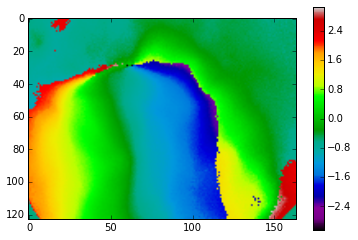

In [400]:
######################################################################
# ABSOLUTE AZIMUTH -- SHIFT NEGATIVE VALS
######################################################################

phase_left = np.angle(leftmap)
phase_right = np.angle(rightmap)

for x in range(phase_left.shape[0]):
    for y in range(phase_left.shape[1]):
        if phase_left[x,y] < 0:
            phase_left[x,y] += 2*math.pi

for x in range(phase_right.shape[0]):
    for y in range(phase_right.shape[1]):
        if phase_right[x,y] < 0:
            phase_right[x,y] += 2*math.pi


az = (phase_left - phase_right) / 2.
plt.imshow(az, cmap='spectral') #, vmin=0, vmax=2*math.pi)
plt.colorbar()

az.min()

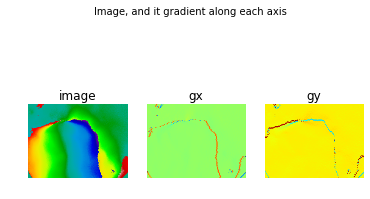

In [401]:
# GRADIENT?

# SHIFT the combined ELEVATION map, too (for gradient calc)

shift_az = (phase_left - phase_right) / 2.
for x in range(shift_az.shape[0]):
    for y in range(shift_az.shape[1]):
        if shift_az[x, y] < 0:
            shift_az[x, y] += 2*math.pi
            
p = az #shift_az
# plt.imshow(p)
gy, gx = np.gradient(p)
# print "gx =", gx
# print "gy =", gy

# plotting
plt.close("all")
plt.figure()
plt.suptitle("Image, and it gradient along each axis")
ax = plt.subplot("131")
ax.axis("off")
ax.imshow(p, cmap='spectral')
ax.set_title("image")

ax = plt.subplot("132")
ax.axis("off")
ax.imshow(gx)
ax.set_title("gx")

ax = plt.subplot("133")
ax.axis("off")
ax.imshow(gy)
ax.set_title("gy")
plt.show()

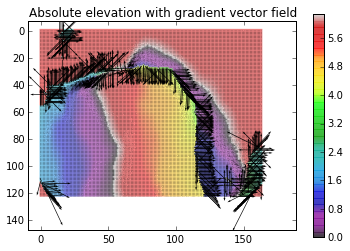

In [402]:
from pylab import *


Q = quiver(gx, gy)

l,r,b,t = axis()
dx, dy = r-l, t-b
axis([l-0.05*dx, r+0.05*dx, b-0.05*dy, t+0.05*dy])

plt.imshow(shift_az, cmap='spectral', alpha=0.5)

plt.gca().invert_yaxis()

plt.colorbar()
plt.title('Absolute elevation with gradient vector field')

-3.0474204577856483

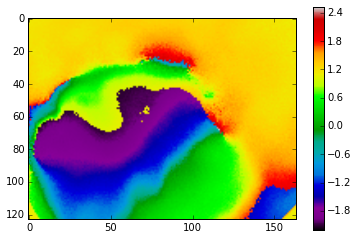

In [257]:
######################################################################
# ABSOLUTE ELEVATION -- SHIFT NEGATIVE VALS
######################################################################

phase_top = np.angle(topmap)
phase_bottom = np.angle(bottommap)

for x in range(phase_top.shape[0]):
    for y in range(phase_top.shape[1]):
        if phase_top[x,y] < 0:
            phase_top[x,y] += 2*math.pi

for x in range(phase_bottom.shape[0]):
    for y in range(phase_bottom.shape[1]):
        if phase_bottom[x,y] < 0:
            phase_bottom[x,y] += 2*math.pi

        
# plt.imshow(phase_left, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
# phase_left

# plt.subplot(1,2,2)
# plt.imshow(phase_right, cmap='spectral')
# plt.colorbar()
        
el = (phase_top - phase_bottom) / 2.
# plt.imshow(az, cmap='spectral') #, vmin=-1*math.pi, vmax=1*math.pi)
plt.imshow(el, cmap='spectral') #, vmin=0, vmax=2*math.pi)
plt.colorbar()
# plt.colorbar()
# x = np.where(phase_left<0)
# len(x[1])
# phase_left.max()
az.min()

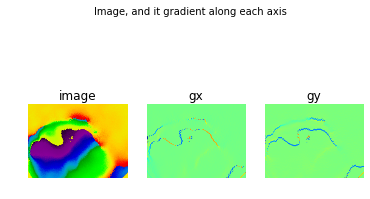

In [258]:
# GRADIENT?

shift_el = (phase_top - phase_bottom) / 2.
for x in range(shift_el.shape[0]):
    for y in range(shift_el.shape[1]):
        if shift_el[x, y] < 0:
            shift_el[x, y] += 2*math.pi
            
p = el #shift_el
# plt.imshow(p)
gy, gx = np.gradient(p)
# print "gx =", gx
# print "gy =", gy

# plotting
plt.close("all")
plt.figure()
plt.suptitle("Image, and it gradient along each axis")
ax = plt.subplot("131")
ax.axis("off")
ax.imshow(p, cmap='spectral')
ax.set_title("image")

ax = plt.subplot("132")
ax.axis("off")
ax.imshow(gx)
ax.set_title("gx")

ax = plt.subplot("133")
ax.axis("off")
ax.imshow(gy)
ax.set_title("gy")
plt.show()

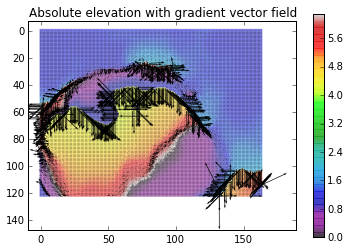

In [259]:
from pylab import *


Q = quiver(gx, gy)

l,r,b,t = axis()
dx, dy = r-l, t-b
axis([l-0.05*dx, r+0.05*dx, b-0.05*dy, t+0.05*dy])

plt.imshow(shift_el, cmap='spectral', alpha=0.5)

plt.gca().invert_yaxis()

plt.colorbar()
plt.title('Absolute elevation with gradient vector field')

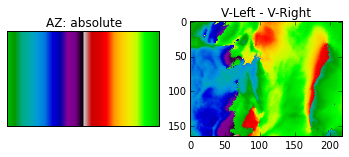

In [214]:
######################################################################
# ABSOLUTE AZIMUTH
######################################################################
# For LEFTMAP - RIGHTMAP, color legend follows LEFT-only map direction:

# phase_left = np.angle(leftmap)
# phase_right = np.angle(rightmap)

# for i in phase_left:
#     if i<0:
#         i += 2*math.pi

azimuth_phase = ( np.angle(leftmap) - np.angle(rightmap) ) / 2.
# azimuth_phase = ( np.angle(leftmap / rightmap) ) / 2.

# SEE ABOVE COLORBAR
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
plt.imshow(V_left_legend, cmap='spectral')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

plt.title('AZ: absolute')
fig.add_subplot(1,2,2)
plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.title('V-Left - V-Right')

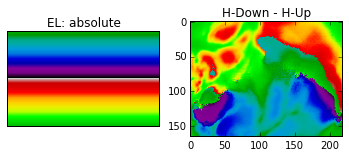

In [215]:
######################################################################
# ABSOLUTE ELEVATION
######################################################################

elevation_phase = ( np.angle(topmap) - np.angle(bottommap) ) / 2.

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
plt.imshow(H_down_legend, cmap='spectral')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

plt.title('EL: absolute')
fig.add_subplot(1,2,2)
plt.imshow(elevation_phase, cmap='spectral',  vmin=-1*math.pi, vmax=1*math.pi)
plt.title('H-Down - H-Up')

(-0.5, 479.5, 299.5, -0.5)

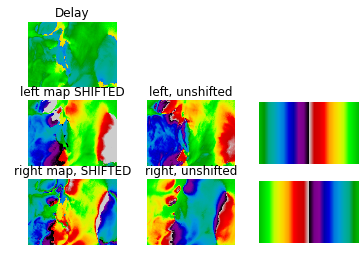

In [219]:
######################################################################
# DELAY VERT:
######################################################################

fig = plt.figure()


colormap = 'spectral'

# 1. Delay map
fig.add_subplot(3,3,1)
# delay_vert = (np.angle(leftmap) + np.angle(rightmap)) / 2.
delay_vert = np.angle(leftmap * rightmap) / 2.
plt.imshow(delay_vert, cmap=colormap,  vmin=-1*math.pi, vmax=1*math.pi)
plt.axis('off')
plt.title("Delay")

# 2. blank

# 3. LEFT-map shifted
fig.add_subplot(3,3,4)
# shift_left = np.angle(leftmap.conjugate()) - delay_vert
shift_left = np.angle(leftmap) - delay_vert
plt.imshow(shift_left, cmap=colormap, vmin=-1*math.pi, vmax=1*math.pi)
plt.axis('off')
plt.title('left map SHIFTED')

# 4. LEFT-map relative
ax = fig.add_subplot(3,3,5)
plt.imshow(np.angle(leftmap), cmap=colormap, vmin=-1*math.pi, vmax=1*math.pi)
plt.axis('off')
plt.title('left, unshifted')

# 5.  LEFT-map LEGEND
ax = fig.add_subplot(3,3,6)
plt.imshow(V_left_legend, cmap=colormap, vmin=-1*math.pi, vmax=1*math.pi)
plt.axis('off')

# 6. RIGHT-map shifted
fig.add_subplot(3,3,7)
# shift_right = np.angle(rightmap) - delay_vert
shift_right = np.angle(rightmap.conjugate()) - delay_vert
plt.imshow(shift_right, cmap=colormap, vmin=-1*math.pi, vmax=1*math.pi)
plt.axis('off')
plt.title('right map, SHIFTED')

# 7. RIGHT-map relative
ax = fig.add_subplot(3,3,8)
plt.imshow(np.angle(rightmap), cmap=colormap, vmin=-1*math.pi, vmax=1*math.pi)
plt.axis('off')
plt.title('right, unshifted')

# 8. RIGHT-map LEGEND
ax = fig.add_subplot(3,3,9)
plt.imshow(V_right_legend, cmap=colormap, vmin=-1*math.pi, vmax=1*math.pi)
plt.axis('off')

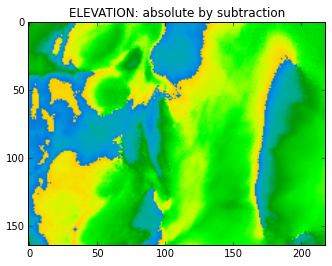

In [217]:
# azimuth_phase = ( np.angle(leftmap) - np.angle(rightmap) ) / 2.
azimuth_phase = ( np.angle(leftmap / rightmap) ) / 2.

plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.title('ELEVATION: absolute by subtraction')

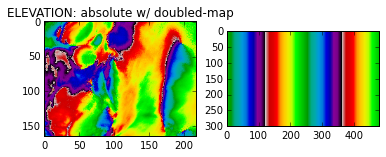

In [218]:
# azimuth_phase = ( np.angle(leftmap) - np.angle(rightmap) ) / 2.
fig = plt.figure()
fig.add_subplot(1,2,1)
azimuth_phase = np.angle(leftmap / rightmap) 
# azimuth_phase = np.angle(rightmap / leftmap) 

plt.imshow(azimuth_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.title('ELEVATION: absolute w/ doubled-map')

fig.add_subplot(1,2,2)
plt.imshow(double_left_legend, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)


(-0.5, 479.5, 299.5, -0.5)

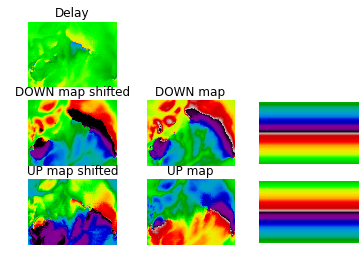

In [220]:
######################################################################
# DELAY HORIZ:
######################################################################

fig = plt.figure()

# 1. Delay map
fig.add_subplot(3,3,1)
delay_horz = np.angle(topmap * bottommap) / 2.
plt.imshow(delay_horz, cmap='spectral',  vmin=-1*math.pi, vmax=1*math.pi)
plt.axis('off')
plt.title("Delay")

# 2. blank

# 3. DOWN-map shifted
fig.add_subplot(3,3,4)
# shift_down = np.angle(downmap.conjugate()) - delay_horz
shift_top = np.angle(topmap) - delay_horz
plt.imshow(shift_top, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.axis('off')
plt.title('DOWN map shifted')

# 4. DOWN-map relative
ax = fig.add_subplot(3,3,5)
plt.imshow(np.angle(topmap), cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.axis('off')
plt.title('DOWN map')

# 5.  Down-map LEGEND
ax = fig.add_subplot(3,3,6)
plt.imshow(H_down_legend, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.axis('off')

# 6. UP-map shifted
fig.add_subplot(3,3,7)
shift_bottom = np.angle(bottommap.conjugate()) - delay_horz
# shift_up = delay_horz - np.angle(upmap.conjugate())
plt.imshow(shift_bottom, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.axis('off')
plt.title('UP map shifted')

# 7. UP-map relative
ax = fig.add_subplot(3,3,8)
plt.imshow(np.angle(bottommap), cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.axis('off')
plt.title('UP map')

# 8. UP-map LEGEND
ax = fig.add_subplot(3,3,9)
plt.imshow(H_up_legend, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.axis('off')

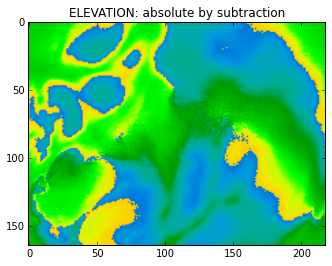

In [221]:
# elevation_phase = ( np.angle(downmap) - np.angle(upmap) ) / 2.
elevation_phase = ( np.angle(topmap / bottommap) ) / 2.

plt.imshow(elevation_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.title('ELEVATION: absolute by subtraction')

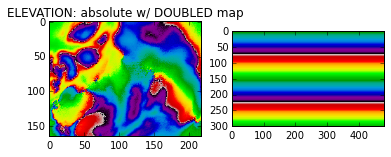

In [222]:
# elevation_phase = ( np.angle(downmap) - np.angle(upmap) ) / 2.
elevation_phase = np.angle(topmap / bottommap)

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(elevation_phase, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)
plt.title('ELEVATION: absolute w/ DOUBLED map')

fig.add_subplot(1,2,2)
plt.imshow(double_down_legend, cmap='spectral', vmin=-1*math.pi, vmax=1*math.pi)

In [22]:
#######################################
# Set THRESHOLD params:
#######################################

thresh = 0.3
log_thresh = 0.3
use_log = 1

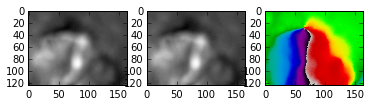

In [23]:

# V-LEFT:
# MASK WITH MAGNITUDE:
# LEFT


curr_key = leftkey

fig = plt.figure()
mag_map = D[curr_key]['mag_map']
phase_map = D[curr_key]['phase_map']

###################################
fig.add_subplot(1,3,1)

plt.imshow(mag_map, cmap='gray')
# plt.colorbar()

###################################
fig.add_subplot(1,3,2)
if use_log:
    [mx, my] = np.where(np.log(mag_map) >= log_thresh*np.log(mag_map.max()))
else:
    [mx, my] = np.where(mag_map >= thresh*mag_map.max())

mask = np.ones(mag_map.shape) * 100
mask[mx, my] = mag_map[mx, my]
[nullx, nully] = np.where(mask == 100)
mask[nullx, nully] = np.nan
mask = np.ma.array(mask)

plt.imshow(mask, cmap='gray')
# plt.colorbar()

###################################
fig.add_subplot(1,3,3)

phase_mask = np.ones(mag_map.shape) * 100
phase_mask[mx, my] = phase_map[mx, my]
phase_mask[nullx, nully] = np.nan
phase_mask = np.ma.array(phase_mask)
plt.imshow(phase_mask, cmap='spectral', vmin=-1*math.pi, vmax=math.pi)

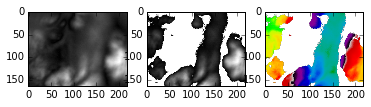

In [225]:
# V-RIGHT:  MASK WITH MAGNITUDE:
# RIGHT 

curr_key = rightkey

fig = plt.figure()
mag_map = D[curr_key]['mag_map']
phase_map = D[curr_key]['phase_map']

###################################
fig.add_subplot(1,3,1)

plt.imshow(mag_map, cmap='gray')
# plt.colorbar()

###################################
fig.add_subplot(1,3,2)
if use_log:
    [mx, my] = np.where(np.log(mag_map) >= log_thresh*np.log(mag_map.max()))
else:
    [mx, my] = np.where(mag_map >= thresh*mag_map.max())

mask = np.ones(mag_map.shape) * 100
mask[mx, my] = mag_map[mx, my]
[nullx, nully] = np.where(mask == 100)
mask[nullx, nully] = np.nan
mask = np.ma.array(mask)

plt.imshow(mask, cmap='gray')
# plt.colorbar()

###################################
fig.add_subplot(1,3,3)

phase_mask = np.ones(mag_map.shape) * 100
phase_mask[mx, my] = phase_map[mx, my]
phase_mask[nullx, nully] = np.nan
phase_mask = np.ma.array(phase_mask)
plt.imshow(phase_mask, cmap='spectral', vmin=-1*math.pi, vmax=math.pi)

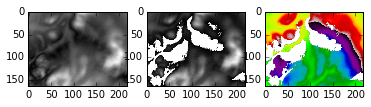

In [226]:
# MASK WITH MAGNITUDE:
# H-DOWN: 

curr_key = topkey

fig = plt.figure()
mag_map = D[curr_key]['mag_map']
phase_map = D[curr_key]['phase_map']

###################################
fig.add_subplot(1,3,1)

plt.imshow(mag_map, cmap='gray')
# plt.colorbar()

###################################
fig.add_subplot(1,3,2)
if use_log:
    [mx, my] = np.where(np.log(mag_map) >= log_thresh*np.log(mag_map.max()))
else:
    [mx, my] = np.where(mag_map >= thresh*mag_map.max())

mask = np.ones(mag_map.shape) * 100
mask[mx, my] = mag_map[mx, my]
[nullx, nully] = np.where(mask == 100)
mask[nullx, nully] = np.nan
mask = np.ma.array(mask)

plt.imshow(mask, cmap='gray')
# plt.colorbar()

###################################
fig.add_subplot(1,3,3)

phase_mask = np.ones(mag_map.shape) * 100
phase_mask[mx, my] = phase_map[mx, my]
phase_mask[nullx, nully] = np.nan
phase_mask = np.ma.array(phase_mask)
plt.imshow(phase_mask, cmap='spectral', vmin=-1*math.pi, vmax=math.pi)

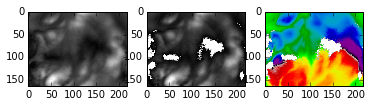

In [227]:
# MASK WITH MAGNITUDE:
# H-UP: 

log_thresh = 0.8
thresh = 0.5
use_log = 1

curr_key = bottomkey

fig = plt.figure()
mag_map = D[curr_key]['mag_map']
phase_map = D[curr_key]['phase_map']

###################################
fig.add_subplot(1,3,1)

plt.imshow(mag_map, cmap='gray')
# plt.colorbar()

###################################
fig.add_subplot(1,3,2)
if use_log:
    [mx, my] = np.where(np.log(mag_map) >= log_thresh*np.log(mag_map.max()))
else:
    [mx, my] = np.where(mag_map >= thresh*mag_map.max())

mask = np.ones(mag_map.shape) * 100
mask[mx, my] = mag_map[mx, my]
[nullx, nully] = np.where(mask == 100)
mask[nullx, nully] = np.nan
mask = np.ma.array(mask)

plt.imshow(mask, cmap='gray')
# plt.colorbar()

###################################
fig.add_subplot(1,3,3)

phase_mask = np.ones(mag_map.shape) * 100
phase_mask[mx, my] = phase_map[mx, my]
phase_mask[nullx, nully] = np.nan
phase_mask = np.ma.array(phase_mask)
plt.imshow(phase_mask, cmap='spectral', vmin=-1*math.pi, vmax=math.pi)

In [129]:
print topkey

Target_fft_H-Down_3_(1, 1)_nas.pkl


0.0
1.0


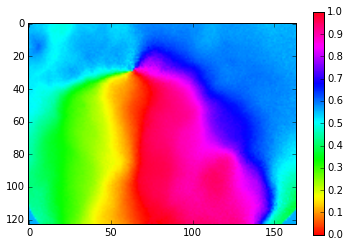

In [163]:
curr_key = leftkey

Ny = len(D[curr_key]['freqs'])/2.
fig = plt.figure()
mag_map = D[curr_key]['mag_map'] / Ny
phase_map = D[curr_key]['phase_map']

plt.imshow(phase_map)

old_min = -math.pi #phase_map.min()
old_max = math.pi #phase_map.max()
new_min = 0
new_max = 1
normed_phase_map = np.zeros(phase_map.shape)
for x in range(phase_map.shape[0]):
    for y in range(phase_map.shape[1]):
        old_val = phase_map[x, y]
        normed_phase_map[x, y] = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min

old_min = mag_map.min()
old_max = mag_map.max()
new_min = 0
new_max = 1
normed_mag_map = np.zeros(mag_map.shape)
for x in range(mag_map.shape[0]):
    for y in range(mag_map.shape[1]):
        old_val = mag_map[x, y]
        normed_mag_map[x, y] = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min


hue = normed_phase_map
sat = np.ones(hue.shape)
val = normed_mag_map

HSV = np.ones(val.shape + (3,))
HSV[...,0] = hue
HSV[...,2] = sat * 1
HSV[...,1] = val

plt.imshow(normed_phase_map, cmap='hsv')
plt.colorbar()

print normed_mag_map.min()
print normed_mag_map.max()


In [166]:

import copy
cutoff = .3*max(normed_mag_map.ravel())
print "Cutoff at: ", cutoff
# thresh_val = copy.deepcopy(val)
nons = []
for x in range(val.shape[0]):
    for y in range(val.shape[1]):
#         print thresh_val[x, y]
        if val[x, y] < cutoff:
            nons.append([x,y])
print len(nons)


# HSV TO RGB:

import colorsys
convmap = np.empty(HSV.shape)

for i in range(HSV.shape[0]):
    for j in range(HSV.shape[1]):

            convmap[i, j, :] = colorsys.hsv_to_rgb(HSV[i,j,:][0],HSV[i,j,:][1],HSV[i,j,:][2])


Cutoff at:  0.3
9017


(123, 164)


<matplotlib.colorbar.Colorbar instance at 0x7f5158329878>

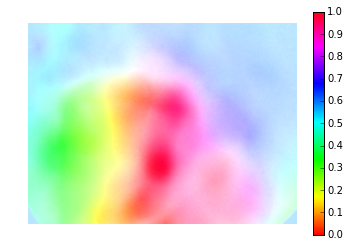

In [167]:
# MASK:

alpha_channel = np.ones(convmap[:,:,1].shape)
print alpha_channel.shape
for i in nons:
    alpha_channel[i[0], i[1]] = 1

composite = np.empty((alpha_channel.shape[0], alpha_channel.shape[1], 4))
composite[:,:,0:3] = convmap[:,:,:]

composite[:,:,3] = alpha_channel

plt.imshow(surface, 'gray')
plt.imshow(composite, 'hsv') #, vmin=0, vmax=1)
plt.axis('off')
plt.colorbar()

In [168]:
D[curr_key].keys()

['phase_map',
 'ft',
 'mag_map',
 'target_freq',
 'mean_intensity',
 'DC_bin',
 'freqs',
 'DC',
 'binsize',
 'dynrange',
 'DC_mag',
 'fps',
 'DC_phase',
 'reduce_factor',
 'nframes',
 'target_bin',
 'DC_freq']

1.27234309398e-13


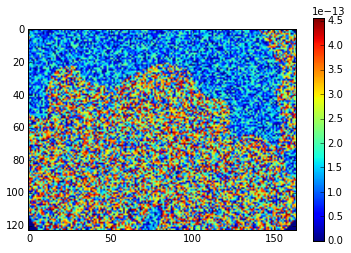

In [172]:
DC_mag = D[curr_key]['DC_mag']/Ny

plt.imshow(D[curr_key]['DC_mag']/Ny)
plt.colorbar()

std_dc = np.std(DC_mag)
print std_dc

In [173]:
std_dc*3

3.8170292819255785e-13